# Загрузка датасета

In [2]:
import os
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import torchvision
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models

In [3]:
# Путь к датасету
dataset_path = "/kaggle/input/animals10/raw-img"

# Словарь перевода категорий
translate = {
    "cane": "dog", "cavallo": "horse", "elefante": "elephant", "farfalla": "butterfly",
    "gallina": "chicken", "gatto": "cat", "mucca": "cow", "pecora": "sheep",
    "ragno": "spider", "scoiattolo": "squirrel"
}

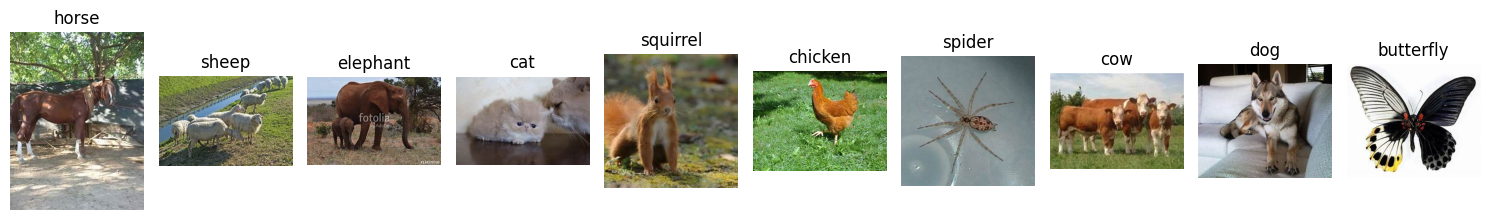

In [4]:
# Получаем список категорий
categories = os.listdir(dataset_path)

# Количество выводимых изображений
num_images = len(categories)

# Создаем графики
fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

for i, category in enumerate(categories):
    category_path = os.path.join(dataset_path, category)
    image_name = os.listdir(category_path)[0]  # Берем первую картинку из папки
    image_path = os.path.join(category_path, image_name)
    
    # Загружаем и преобразуем изображение
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Выводим изображение
    axes[i].imshow(img)
    axes[i].axis("off")
    axes[i].set_title(translate.get(category, category))  # Переводим название

plt.tight_layout()
plt.show()

# Предобработка

In [5]:
# Определяем трансформации (нормализация в [0,1])
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Приводим к единому размеру
    transforms.RandomHorizontalFlip(),  # Случайное отражение
    transforms.RandomRotation(10),  # Случайный поворот
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Яркость и контраст
    transforms.ToTensor(),  # Конвертируем в тензор (достаточно один раз!)
    transforms.Normalize(mean=[0.5], std=[0.5])  # Нормализация
])

# Загружаем датасет
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

# Разделяем на обучающую и валидационную выборку
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Создаем DataLoader для загрузки батчами
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Проверим размер данных
images, labels = next(iter(train_loader))
print(f"Размер батча: {images.shape}")  # (batch_size, channels, height, width)
print(f"Минимальное значение пикселя: {images.min()}, Максимальное: {images.max()}")

Размер батча: torch.Size([32, 3, 128, 128])
Минимальное значение пикселя: -1.0, Максимальное: 1.0


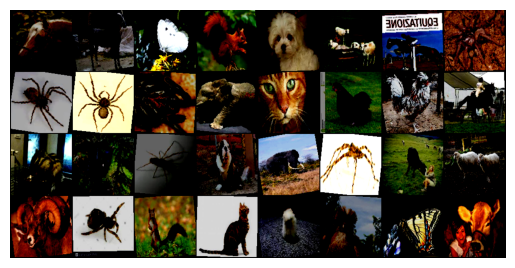

horse      horse      butterfly  squirrel   dog        cow        horse      spider     spider     spider     spider     elephant   cat        chicken    chicken    horse      squirrel   chicken    spider     dog        elephant   spider     cow        sheep      sheep      spider     squirrel   cat        dog        chicken    butterfly  cow       


In [7]:
# Функция для отображения изображений
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis("off")  # Убираем оси для чистоты
    plt.show()

# Получаем несколько случайных обучающих изображений
dataiter = iter(train_loader)  # dataloader уже загружен ранее
images, labels = next(dataiter)

# Вывести изображения
imshow(torchvision.utils.make_grid(images))

# Получаем список классов из датасета
class_names = dataset.classes  # classes уже загружены в dataset
translated_classes = [translate.get(c, c) for c in class_names]  # Переводим названия

# Вывести классы изображений
print(' '.join(f'{translated_classes[labels[j]]:10s}' for j in range(len(images))))

# Обучение модели

In [9]:
# Модель
class Net(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)  # Больше фильтров
        self.bn1 = nn.BatchNorm2d(32)  
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)  
        self.bn3 = nn.BatchNorm2d(128)  
        
        self.pool = nn.MaxPool2d(2, 2)  

        self.fc1 = nn.Linear(128 * 16 * 16, 512)  # Adapted for 128 feature maps
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)

        self.dropout = nn.Dropout(0.5)  # Добавляем dropout для защиты от переобучения

    def forward(self, x):
        x = self.pool(F.leaky_relu(self.bn1(self.conv1(x))))
        x = self.pool(F.leaky_relu(self.bn2(self.conv2(x))))
        x = self.pool(F.leaky_relu(self.bn3(self.conv3(x))))
        
        x = torch.flatten(x, 1)  
        x = F.leaky_relu(self.fc1(x))
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x))
        x = self.fc3(x)
        return x


# Инициализация модели
net = Net(len(dataset.classes))

# Выбор функции потерь и оптимизатора
criterion = nn.CrossEntropyLoss()  # Кросс-энтропия для многоклассовой классификации
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# Обучение модели
num_epochs = 5
for epoch in range(num_epochs):
    running_loss = 0.0
    for inputs, labels in train_loader:
        # Обнуляем градиенты
        optimizer.zero_grad()

        # Прямой проход
        outputs = net(inputs)

        # Вычисление потерь
        loss = criterion(outputs, labels)

        # Обратный проход и оптимизация
        loss.backward()
        optimizer.step()

        # Статистика
        running_loss += loss.item()

    print(f"Эпоха {epoch + 1}, Потери: {running_loss / len(train_loader)}")

print('Обучение завершено')

Эпоха 1, Потери: 1.836596479488693
Эпоха 2, Потери: 1.476260664171845
Эпоха 3, Потери: 1.3422954394617153
Эпоха 4, Потери: 1.2458776645988
Эпоха 5, Потери: 1.180691519675364
Обучение завершено


In [10]:
model_scripted = torch.jit.script(net) # Export to TorchScript
model_scripted.save('BasicNet.pt')

In [8]:
net = torch.jit.load('/kaggle/input/models/BasicNet.pt')
net.eval()

RecursiveScriptModule(
  original_name=Net
  (conv1): RecursiveScriptModule(original_name=Conv2d)
  (bn1): RecursiveScriptModule(original_name=BatchNorm2d)
  (conv2): RecursiveScriptModule(original_name=Conv2d)
  (bn2): RecursiveScriptModule(original_name=BatchNorm2d)
  (conv3): RecursiveScriptModule(original_name=Conv2d)
  (bn3): RecursiveScriptModule(original_name=BatchNorm2d)
  (pool): RecursiveScriptModule(original_name=MaxPool2d)
  (fc1): RecursiveScriptModule(original_name=Linear)
  (fc2): RecursiveScriptModule(original_name=Linear)
  (fc3): RecursiveScriptModule(original_name=Linear)
  (dropout): RecursiveScriptModule(original_name=Dropout)
)

In [11]:
class DeeperNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)

        self.pool = nn.MaxPool2d(2, 2)

        self.shortcut = nn.Conv2d(128, 256, kernel_size=1)  

        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))  
        
        self.fc1 = nn.Linear(256, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.leaky_relu(self.bn1(self.conv1(x))))
        x = self.pool(F.leaky_relu(self.bn2(self.conv2(x))))
        x = self.pool(F.leaky_relu(self.bn3(self.conv3(x))))

        residual = self.shortcut(x)
        x = F.leaky_relu(self.bn4(self.conv4(x)) + residual)  

        x = self.global_pool(x)
        x = torch.flatten(x, 1)
        x = F.leaky_relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x
        
# Инициализация модели
deeperNet = DeeperNet(len(dataset.classes))

# Выбор функции потерь и оптимизатора
criterion = nn.CrossEntropyLoss()  # Кросс-энтропия для многоклассовой классификации
optimizer = optim.SGD(deeperNet.parameters(), lr=0.001, momentum=0.9)

# Обучение модели
num_epochs = 5
for epoch in range(num_epochs):
    running_loss = 0.0
    for inputs, labels in train_loader:
        # Обнуляем градиенты
        optimizer.zero_grad()

        # Прямой проход
        outputs = deeperNet(inputs)

        # Вычисление потерь
        loss = criterion(outputs, labels)

        # Обратный проход и оптимизация
        loss.backward()
        optimizer.step()

        # Статистика
        running_loss += loss.item()

    print(f"Эпоха {epoch + 1}, Потери: {running_loss / len(train_loader)}")

print('Обучение завершено')

Эпоха 1, Потери: 2.0631701842519163
Эпоха 2, Потери: 1.8383805504282011
Эпоха 3, Потери: 1.6743141199796254
Эпоха 4, Потери: 1.5626074498846332
Эпоха 5, Потери: 1.4795049165041392
Обучение завершено


In [12]:
model_scripted = torch.jit.script(deeperNet) # Export to TorchScript
model_scripted.save('deeper_net.pt')

In [9]:
deeperNet = torch.jit.load('/kaggle/input/models/deeper_net.pt')
deeperNet.eval()

RecursiveScriptModule(
  original_name=DeeperNet
  (conv1): RecursiveScriptModule(original_name=Conv2d)
  (bn1): RecursiveScriptModule(original_name=BatchNorm2d)
  (conv2): RecursiveScriptModule(original_name=Conv2d)
  (bn2): RecursiveScriptModule(original_name=BatchNorm2d)
  (conv3): RecursiveScriptModule(original_name=Conv2d)
  (bn3): RecursiveScriptModule(original_name=BatchNorm2d)
  (conv4): RecursiveScriptModule(original_name=Conv2d)
  (bn4): RecursiveScriptModule(original_name=BatchNorm2d)
  (pool): RecursiveScriptModule(original_name=MaxPool2d)
  (shortcut): RecursiveScriptModule(original_name=Conv2d)
  (global_pool): RecursiveScriptModule(original_name=AdaptiveAvgPool2d)
  (fc1): RecursiveScriptModule(original_name=Linear)
  (fc2): RecursiveScriptModule(original_name=Linear)
  (dropout): RecursiveScriptModule(original_name=Dropout)
)

In [6]:
class AdaptiveELU_Net(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)  
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)  
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)  
        self.bn4 = nn.BatchNorm2d(256)
        
        self.conv1x1 = nn.Conv2d(256, 128, kernel_size=1)  # Уменьшаем размерность
        
        self.pool = nn.MaxPool2d(2, 2)
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))  # Глобальный усредняющий пуллинг
        
        self.fc1 = nn.Linear(128, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)

        self.dropout = nn.Dropout(0.4)
    
    def forward(self, x):
        x = self.pool(F .elu(self.bn1(self.conv1(x))))
        x = self.pool(F.elu(self.bn2(self.conv2(x))))
        x = self.pool(F.elu(self.bn3(self.conv3(x))))
        x = self.pool(F.elu(self.bn4(self.conv4(x))))
        
        x = self.conv1x1(x)
        x = self.global_pool(x)
        
        x = torch.flatten(x, 1)
        x = F.elu(self.fc1(x))
        x = self.dropout(x)
        x = F.elu(self.fc2(x))
        x = self.fc3(x)
        return x

        
# Инициализация модели
adaptiveELU_Net = AdaptiveELU_Net(len(dataset.classes))

# Выбор функции потерь и оптимизатора
criterion = nn.CrossEntropyLoss()  # Кросс-энтропия для многоклассовой классификации
optimizer = optim.SGD(adaptiveELU_Net.parameters(), lr=0.001, momentum=0.9)

# Обучение модели
num_epochs = 5
for epoch in range(num_epochs):
    running_loss = 0.0
    for inputs, labels in train_loader:
        # Обнуляем градиенты
        optimizer.zero_grad()

        # Прямой проход
        outputs = adaptiveELU_Net(inputs)

        # Вычисление потерь
        loss = criterion(outputs, labels)

        # Обратный проход и оптимизация
        loss.backward()
        optimizer.step()

        # Статистика
        running_loss += loss.item()

    print(f"Эпоха {epoch + 1}, Потери: {running_loss / len(train_loader)}")

print('Обучение завершено')

Эпоха 1, Потери: 2.109808282269776
Эпоха 2, Потери: 1.8695082629909952
Эпоха 3, Потери: 1.6941546087046615
Эпоха 4, Потери: 1.5938479616441799
Эпоха 5, Потери: 1.534628112261532
Обучение завершено


In [7]:
model_scripted = torch.jit.script(adaptiveELU_Net) # Export to TorchScript
model_scripted.save('adaptiveELU_Net.pt')

In [10]:
adaptiveELU_Net = torch.jit.load('/kaggle/input/models/adaptiveELU_Net.pt')
adaptiveELU_Net.eval()

RecursiveScriptModule(
  original_name=AdaptiveELU_Net
  (conv1): RecursiveScriptModule(original_name=Conv2d)
  (bn1): RecursiveScriptModule(original_name=BatchNorm2d)
  (conv2): RecursiveScriptModule(original_name=Conv2d)
  (bn2): RecursiveScriptModule(original_name=BatchNorm2d)
  (conv3): RecursiveScriptModule(original_name=Conv2d)
  (bn3): RecursiveScriptModule(original_name=BatchNorm2d)
  (conv4): RecursiveScriptModule(original_name=Conv2d)
  (bn4): RecursiveScriptModule(original_name=BatchNorm2d)
  (conv1x1): RecursiveScriptModule(original_name=Conv2d)
  (pool): RecursiveScriptModule(original_name=MaxPool2d)
  (global_pool): RecursiveScriptModule(original_name=AdaptiveAvgPool2d)
  (fc1): RecursiveScriptModule(original_name=Linear)
  (fc2): RecursiveScriptModule(original_name=Linear)
  (fc3): RecursiveScriptModule(original_name=Linear)
  (dropout): RecursiveScriptModule(original_name=Dropout)
)

In [11]:
models = {
    "Baseline": net,  # Ваша исходная модель
    "DeeperNet": deeperNet,
    "AdaptiveELU_Net": adaptiveELU_Net
}
# Отключаем вычисление градиентов во время тестирования
with torch.no_grad():
    for name, model in models.items():
        correct = 0
        total = 0
        
        for data in val_loader:
            images, labels = data  # Переносим на GPU, если используется
            outputs = model(images)
            
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        print(f'Accuracy of {name} on {total} test images: {accuracy:.2f}%')


Accuracy of Baseline on 5236 test images: 62.59%
Accuracy of DeeperNet on 5236 test images: 49.81%
Accuracy of AdaptiveELU_Net on 5236 test images: 47.27%


In [12]:
from tabulate import tabulate
models = {
    "Baseline": net,  # Ваша исходная модель
    "DeeperNet": deeperNet,
    "AdaptiveELU_Net": adaptiveELU_Net
}
model_accuracies = {}  # Словарь для хранения точности каждой модели по классам
with torch.no_grad():
    for name, model in models.items():
        correct_pred = {classname: 0 for classname in dataset.classes}
        total_pred = {classname: 0 for classname in dataset.classes}

        for data in val_loader:
            images, labels = data
            outputs = model(images)
            _, predictions = torch.max(outputs, 1)

            # Считаем правильные предсказания по каждому классу
            for label, prediction in zip(labels, predictions):
                if label == prediction:
                    correct_pred[dataset.classes[label]] += 1
                total_pred[dataset.classes[label]] += 1

        # Сохраняем точности для этой модели
        model_accuracies[name] = {}
        for classname, correct_count in correct_pred.items():
            accuracy = 100 * float(correct_count) / total_pred[classname] if total_pred[classname] > 0 else 0
            model_accuracies[name][classname] = accuracy

# Подготовка данных для таблицы
table_data = []
header = ["Class Name (Translated)", "Class Name (Original)"]

# Добавляем заголовки для каждой модели
for model_name in models.keys():
    header.append(f"Accuracy ({model_name})")

# Заполняем данные таблицы
for classname in dataset.classes:
    translated_name = translate.get(classname, classname)  # Перевод имени класса
    row = [translated_name, classname]
    for model_name in models.keys():
        row.append(f"{model_accuracies[model_name].get(classname, 0):.1f} %")
    table_data.append(row)

# Вывод таблицы
print("\nAccuracy comparison for each class:")
print(tabulate(table_data, headers=header, tablefmt="grid"))



Accuracy comparison for each class:
+---------------------------+-------------------------+-----------------------+------------------------+------------------------------+
| Class Name (Translated)   | Class Name (Original)   | Accuracy (Baseline)   | Accuracy (DeeperNet)   | Accuracy (AdaptiveELU_Net)   |
+===========================+=========================+=======================+========================+==============================+
| dog                       | cane                    | 67.2 %                | 50.5 %                 | 66.1 %                       |
+---------------------------+-------------------------+-----------------------+------------------------+------------------------------+
| horse                     | cavallo                 | 53.7 %                | 45.4 %                 | 33.1 %                       |
+---------------------------+-------------------------+-----------------------+------------------------+------------------------------+
| elephant 

# Проверка работы


Predictions from different models:
+-----------------+-------------------+
| Model Name      | Predicted Class   |
+=================+===================+
| Baseline        | spider            |
+-----------------+-------------------+
| DeeperNet       | spider            |
+-----------------+-------------------+
| AdaptiveELU_Net | spider            |
+-----------------+-------------------+


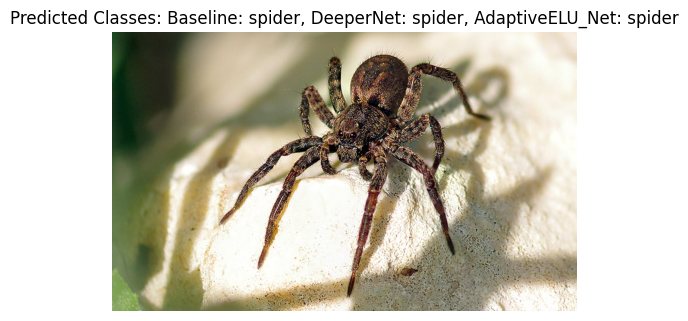

In [21]:
from PIL import Image
# Путь к изображению
image_path = '/kaggle/input/horse-img/spider2.jpg'
image = Image.open(image_path)

# Применить трансформации к изображению
image_tensor = transform(image).unsqueeze(0)  # Добавляем batch размерность

# Словарь для хранения предсказаний
model_predictions = {}

# Отключаем вычисление градиентов
with torch.no_grad():
    # Пропускаем изображение через все модели
    for name, model in models.items():
        output = model(image_tensor)  # Пропускаем изображение через модель
        _, predicted = torch.max(output, 1)  # Получаем индекс класса с максимальной вероятностью
        
        # Получаем метку класса
        class_idx = predicted.item()
        class_name = dataset.classes[class_idx]
        
        # Сохраняем предсказания для модели
        model_predictions[name] = translate.get(class_name, class_name)

# Подготовка данных для таблицы
table_data = []
header = ["Model Name", "Predicted Class"]

# Заполняем данные для таблицы
for model_name, predicted_class in model_predictions.items():
    table_data.append([model_name, predicted_class])

# Выводим таблицу с предсказаниями
print("\nPredictions from different models:")
print(tabulate(table_data, headers=header, tablefmt="grid"))

# Выводим изображение с предсказаниями
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(image)
ax.set_title('Predicted Classes: ' + ', '.join(f'{name}: {class_name}' for name, class_name in model_predictions.items()))
ax.axis('off')  # Убираем оси
plt.show()

# Transfer learning

In [11]:
from torchvision import models
from torchvision.models.resnet import resnet18
from torch.hub import load_state_dict_from_url

# Создаем модель без предобученных весов
model = models.resnet18(weights=None)

# Загружаем веса из локального файла
weights_path = "/kaggle/input/models/resnet18-f37072fd.pth"
state_dict = torch.load(weights_path, map_location=torch.device("cpu"))

# Применяем веса к модели
model.load_state_dict(state_dict)

# Заменяем последний слой для нашего количества классов
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)  # 10 классов

# Переносим модель на GPU, если доступно
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Определяем функцию потерь и оптимизатор
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Обучение модели
epochs = 5
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}")

# Оценка модели
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Validation Accuracy: {100 * correct / total:.2f}%")


<ipython-input-11-5ca234231a6f>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(weights_path, map_location=torch.device("cpu"))


Epoch 1, Loss: 0.8690
Epoch 2, Loss: 0.5908
Epoch 3, Loss: 0.4894
Epoch 4, Loss: 0.4128
Epoch 5, Loss: 0.3747
Validation Accuracy: 84.68%


In [12]:
model_scripted = torch.jit.script(model) # Export to TorchScript
model_scripted.save('model_transfer.pt')

In [6]:
transfer_model = torch.jit.load('/kaggle/input/models/model_transfer.pt')
transfer_model.eval()

RecursiveScriptModule(
  original_name=ResNet
  (conv1): RecursiveScriptModule(original_name=Conv2d)
  (bn1): RecursiveScriptModule(original_name=BatchNorm2d)
  (relu): RecursiveScriptModule(original_name=ReLU)
  (maxpool): RecursiveScriptModule(original_name=MaxPool2d)
  (layer1): RecursiveScriptModule(
    original_name=Sequential
    (0): RecursiveScriptModule(
      original_name=BasicBlock
      (conv1): RecursiveScriptModule(original_name=Conv2d)
      (bn1): RecursiveScriptModule(original_name=BatchNorm2d)
      (relu): RecursiveScriptModule(original_name=ReLU)
      (conv2): RecursiveScriptModule(original_name=Conv2d)
      (bn2): RecursiveScriptModule(original_name=BatchNorm2d)
    )
    (1): RecursiveScriptModule(
      original_name=BasicBlock
      (conv1): RecursiveScriptModule(original_name=Conv2d)
      (bn1): RecursiveScriptModule(original_name=BatchNorm2d)
      (relu): RecursiveScriptModule(original_name=ReLU)
      (conv2): RecursiveScriptModule(original_name=Conv2d)

In [7]:
from tabulate import tabulate
models = {
    "transfer_model": transfer_model
}
model_accuracies = {}  # Словарь для хранения точности каждой модели по классам
with torch.no_grad():
    for name, model in models.items():
        correct_pred = {classname: 0 for classname in dataset.classes}
        total_pred = {classname: 0 for classname in dataset.classes}

        for data in val_loader:
            images, labels = data
            outputs = model(images)
            _, predictions = torch.max(outputs, 1)

            # Считаем правильные предсказания по каждому классу
            for label, prediction in zip(labels, predictions):
                if label == prediction:
                    correct_pred[dataset.classes[label]] += 1
                total_pred[dataset.classes[label]] += 1

        # Сохраняем точности для этой модели
        model_accuracies[name] = {}
        for classname, correct_count in correct_pred.items():
            accuracy = 100 * float(correct_count) / total_pred[classname] if total_pred[classname] > 0 else 0
            model_accuracies[name][classname] = accuracy

# Подготовка данных для таблицы
table_data = []
header = ["Class Name (Translated)", "Class Name (Original)"]

# Добавляем заголовки для каждой модели
for model_name in models.keys():
    header.append(f"Accuracy ({model_name})")

# Заполняем данные таблицы
for classname in dataset.classes:
    translated_name = translate.get(classname, classname)  # Перевод имени класса
    row = [translated_name, classname]
    for model_name in models.keys():
        row.append(f"{model_accuracies[model_name].get(classname, 0):.1f} %")
    table_data.append(row)

# Вывод таблицы
print("\nAccuracy comparison for each class:")
print(tabulate(table_data, headers=header, tablefmt="grid"))


Accuracy comparison for each class:
+---------------------------+-------------------------+-----------------------------+
| Class Name (Translated)   | Class Name (Original)   | Accuracy (transfer_model)   |
+===========================+=========================+=============================+
| dog                       | cane                    | 84.4 %                      |
+---------------------------+-------------------------+-----------------------------+
| horse                     | cavallo                 | 78.7 %                      |
+---------------------------+-------------------------+-----------------------------+
| elephant                  | elefante                | 89.9 %                      |
+---------------------------+-------------------------+-----------------------------+
| butterfly                 | farfalla                | 91.6 %                      |
+---------------------------+-------------------------+-----------------------------+
| chicken        


Predictions from different models:
+----------------+-------------------+
| Model Name     | Predicted Class   |
+================+===================+
| transfer_model | horse             |
+----------------+-------------------+


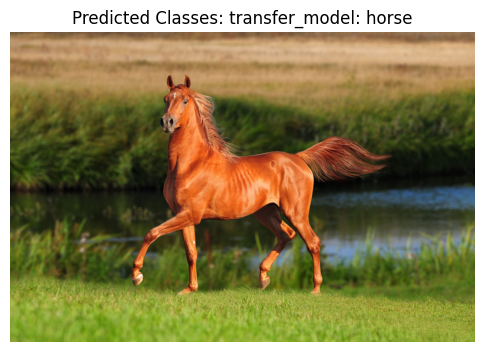

In [11]:
from PIL import Image
# Путь к изображению
image_path = '/kaggle/input/horse-img/horse.jpg'
image = Image.open(image_path)

# Применить трансформации к изображению
image_tensor = transform(image).unsqueeze(0)  # Добавляем batch размерность

# Словарь для хранения предсказаний
model_predictions = {}

# Отключаем вычисление градиентов
with torch.no_grad():
    # Пропускаем изображение через все модели
    for name, model in models.items():
        output = model(image_tensor)  # Пропускаем изображение через модель
        _, predicted = torch.max(output, 1)  # Получаем индекс класса с максимальной вероятностью
        
        # Получаем метку класса
        class_idx = predicted.item()
        class_name = dataset.classes[class_idx]
        
        # Сохраняем предсказания для модели
        model_predictions[name] = translate.get(class_name, class_name)

# Подготовка данных для таблицы
table_data = []
header = ["Model Name", "Predicted Class"]

# Заполняем данные для таблицы
for model_name, predicted_class in model_predictions.items():
    table_data.append([model_name, predicted_class])

# Выводим таблицу с предсказаниями
print("\nPredictions from different models:")
print(tabulate(table_data, headers=header, tablefmt="grid"))

# Выводим изображение с предсказаниями
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(image)
ax.set_title('Predicted Classes: ' + ', '.join(f'{name}: {class_name}' for name, class_name in model_predictions.items()))
ax.axis('off')  # Убираем оси
plt.show()